In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import numpy.matlib as mat
from My_functions import reverse_colourmap


In [2]:
prefix = "_migration"

files_home = "/data/rd_exchange/mbelharet/nemo_4.0_fabm_pisces"

filename = "C1D_PAPA_fabm" + prefix + "_1ts_20100615_20110614_diad_T.nc"  



In [3]:
data = xr.open_dataset(files_home + "/" + filename).isel(x=1, y=1)

##### depth of vertical levels ######
depth = data['deptht'].to_numpy()
##### time counter ##################
time_counter = data['time_counter'].to_numpy()

In [4]:
ncVars = ["par","par0","parmean","thickness"]

In [5]:
par_upper_bottom_percent = 0.05e-2
par_ez_percent = 0.5e-2
par_lower_bottom_percent = 0.00001e-2

In [6]:
id = -1

for ncVar in ncVars:
    exec(ncVar + "_fabm= data"  +"[\"" + ncVar + "\"].to_numpy()")


parmean0_fabm = parmean_fabm[:,0]
#par_fabm = 1e-5*np.ones(par_fabm.shape)


In [7]:
print(par_fabm.shape)
print(par0_fabm.shape)
print(parmean_fabm.shape)
print(par0_fabm.size)
print(thickness_fabm.shape)

(8760, 75)
(8760,)
(8760, 75)
8760
(8760, 75)


In [8]:
present = np.empty(par_fabm.shape)
local_random = np.empty(par_fabm.shape)

for i in range(0,par0_fabm.size):
    par0 = par0_fabm[i]
    parmean0 = parmean0_fabm[i]
    if (par0 < 1e-4) :
        ratio = 1.0
        upper = (1.0 - par_upper_bottom_percent) * ratio + par_upper_bottom_percent
        lower = (par_ez_percent - par_lower_bottom_percent) * ratio + par_lower_bottom_percent
    else:
        ratio = min( par0/parmean0, 1.0 )
        upper = (1.0 - par_upper_bottom_percent) * pow((1.0 - ratio),4.0) + par_upper_bottom_percent
        lower = (par_ez_percent - par_lower_bottom_percent) * pow((1.0 - ratio/(ratio+0.35)),8.0) + par_lower_bottom_percent

    percent_upper_random = np.random.rand()
    percent_upper_random = -0.75 + (0.75 - (-0.75)) * percent_upper_random
    upper = upper + percent_upper_random * upper
    percent_lower_random = np.random.rand()
    percent_lower_random = -0.75 + (0.75 - (-0.75)) * percent_lower_random
    lower = lower + percent_lower_random * lower

    totaldepth = 0
    
    for k in range(0,par_fabm.shape[1]):
        par = par_fabm[i,k]
        parmean = parmean_fabm[i,k]
        if (par0 < 1.e-4):
            if ((parmean <= upper * parmean0) and (parmean >= lower * parmean0)):
                present[i,k] = 1
            else:
                present[i,k] = 0
        else:
            if ((par <= upper * par0) and (par >= lower * par0)):
                present[i,k] = 1
            else:
                present[i,k] = 0

    ###########################################################################################
    # Vertical distribution 
    ###########################################################################################
        thickness = thickness_fabm[i,k]
        totaldepth += thickness
        local_random[i,k] = np.random.rand()
        minimum_random = np.random.rand()
        minimum_value = 0.02 + (0.1 - 0.02) * minimum_random
        if (parmean0 < 1e-4):
            if (totaldepth <= 400.0):
                local_random[i,k] = (minimum_value + (1.0 - minimum_value) * local_random) * thickness
            else:
                local_random[i,k] = minimum_value  * thickness
        else:
            local_random[i,k] = (minimum_value + (1.0 - minimum_value) * local_random[i,k] * present[i,k]) * thickness
        
         



In [9]:
integral_random = mat.repmat(np.nansum(local_random, axis=1),depth.size,1)
distributed = local_random / np.transpose(integral_random)

In [10]:
flags = ["_fabm"]
def plot_variables(variables, depth_level):
    fig = plt.figure(figsize=(10,6))
    nb = int(np.ceil(len(variables)/2))
    cptr = 0
    
    for var in variables:
        cptr+=1
        ax = fig.add_subplot(nb,2,cptr)
        for flag in flags:
            ldict = {}
            exec("v =" +  var + flag , globals(),ldict)
            v = ldict['v'] 
            print(v.shape)
            if(v.ndim == 1):
                v_mean = v
            elif(v.ndim == 2):
                v_mean = v[:,depth_level]
            else:
                print("coucou")
               
            plt.plot(v_mean[ndt_min:ndt_max])
            
        
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.title(var , fontsize=12) 
        plt.ylabel("$µmol\ L^{-1}$",fontsize=8)
        plt.xlabel("Time (h)",fontsize=8)
        plt.legend(["with FABM", "standard"])

    # Space between subplots
    fig.tight_layout(pad=1.5)

In [11]:

def plot_hovmoller(variables, depth_limits, time_limits):
    depth_min = depth_limits[0]
    depth_max = depth_limits[1]
    dep_min_id = np.asarray(np.where(depth>=depth_min))[0,0]
    dep_max_id = np.asarray(np.where(depth<=depth_max))[0,-1]

    ndt_min = time_limits[0]
    ndt_max = time_limits[1]
    

    fig = plt.figure(figsize=(10,6))
    my_cmap = reverse_colourmap(plt.cm.Spectral)
    
    nb = int(np.ceil(len(variables)/2))
    cptr = 0
    for var in variables:
        cptr+=1
        ax = fig.add_subplot(2,2,cptr)
        ldict = {}
        exec("v_fabm =" +  var + "_fabm[" + str(ndt_min) + ":" + str(ndt_max) + "," + str(dep_min_id) + ":" + str(dep_max_id) + "]", globals(),ldict)
        v_fabm = ldict['v_fabm']

        v_anomaly = np.transpose(v_fabm)

        x = np.arange(0,v_anomaly.shape[1])*t_step
        [X,dep] = np.meshgrid(x,depth[dep_min_id:dep_max_id])
        
        pc = ax.pcolormesh(X,-dep,v_anomaly,cmap=my_cmap,shading="gouraud")
        clb=fig.colorbar(pc)
        #pc.set_clim(0,10)
        plt.title(var , fontsize=12)
        plt.xlabel("Time (h)")
        plt.ylabel("Depth (m)")

    # Space between subplots
    fig.tight_layout(pad=1.5)


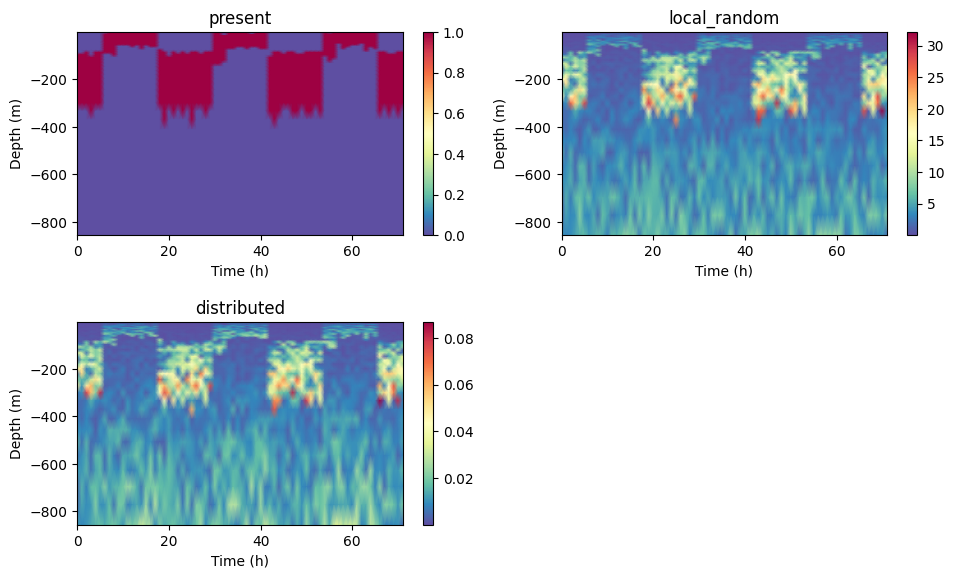

In [12]:
t_step = 1
ndt_min = 24*362
ndt_max = 24*365

present_fabm = present
distributed_fabm = distributed
local_random_fabm = local_random

variables = ["present","local_random","distributed"]
depth_limits = np.array([0, 1000])
time_limits = np.array([ndt_min, ndt_max])


plot_hovmoller(variables, depth_limits, time_limits)

In [13]:
##########################################################################################################################################
# SIMULATION
##########################################################################################################################################

In [14]:
meso_conc_prev = 1.e-2 * np.ones(distributed.shape[1]) # mmol m-3
#print(meso_conc_prev.shape)
     
run_time = distributed.shape[0]

meso_conc = np.empty(distributed.shape)
meso_conc[0,:] = meso_conc_prev
toto = np.empty(distributed.shape)
meso_int = np.empty(distributed.shape)


for t in range(1,run_time):
    th = thickness_fabm[0,:]
    d = distributed[t,:]
    meso_conc_int = np.nansum(meso_conc_prev * th) #mmol m-2
          
    dc = -meso_conc_prev + (d * meso_conc_int/th) # mmol m-3
    
    
    toto[t-1,:] = (d * meso_conc_int) #/th
    meso_conc_prev = meso_conc_prev + dc
    meso_conc[t,:] = meso_conc_prev   
    
    
    meso_int[t-1] = meso_conc_int
    #meso_conc = np.concatenate((meso_conc,meso_conc_prev), axis = 1)



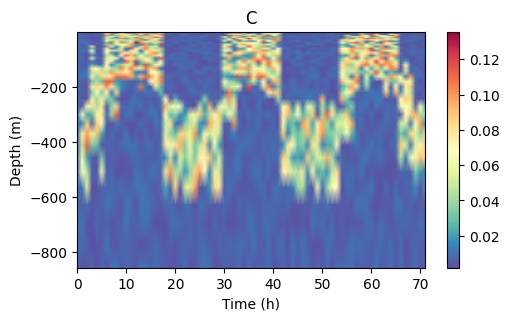

In [15]:
C_fabm = meso_conc
plot_hovmoller(["C"], depth_limits, [0,24*3] )

(8760, 75)
(8760,)
(8760,)


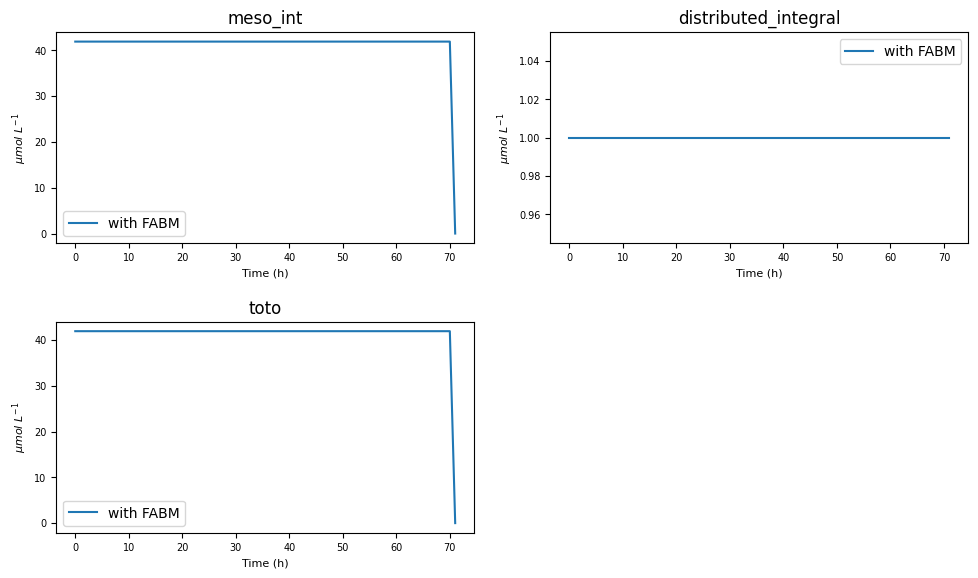

In [16]:
distributed_integral_fabm =  np.nansum(distributed, axis=1)
toto_fabm =  np.nansum(toto, axis=1)

meso_int_fabm = meso_int
plot_variables(["meso_int","distributed_integral","toto"],0)

In [17]:
toto[1,:]

array([9.27545726e-03, 1.12095791e-02, 3.47846641e-03, 6.25232115e-03,
       1.46420154e-02, 9.62232632e-03, 6.40449451e-03, 9.32805576e-03,
       1.33325867e-02, 1.55524631e-02, 1.48479971e-02, 1.96088852e-02,
       3.27337490e-02, 2.85263459e-02, 3.41090406e-02, 3.46017348e-02,
       5.20021205e-02, 7.10484435e-02, 5.87255307e-02, 6.07952127e-02,
       8.29303772e-02, 2.05828022e-02, 2.60842352e-02, 2.61036743e-02,
       6.38854011e-02, 6.51429153e-02, 1.03133181e-01, 1.65986336e-01,
       1.71419886e-01, 8.01781930e-02, 7.78538538e-02, 1.05596658e-01,
       6.00495343e-02, 2.02183472e+00, 6.85505718e-01, 3.02809871e+00,
       3.79056823e+00, 4.86838795e+00, 1.00469405e+00, 2.42674215e+00,
       3.22516515e+00, 6.41547989e-01, 1.89814310e-01, 5.83276584e-01,
       3.40603097e-01, 6.99797641e-01, 2.90570435e-01, 7.50820702e-01,
       8.61617336e-01, 1.04888493e+00, 1.45312637e+00, 3.85065079e-01,
       3.84469668e-01, 3.83142655e-01, 1.00109254e+00, 9.01044151e-01,
      